In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:
df=pd.read_csv('Churn_Modelling.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
numeric_df = df.select_dtypes(include=['number'])
correlations = numeric_df.corr()
correlations['Exited']

,Exited
RowNumber,-0.016571
CustomerId,-0.006248
CreditScore,-0.027094
Age,0.285323
Tenure,-0.014001
Balance,0.118533
NumOfProducts,-0.047820
HasCrCard,-0.007138
IsActiveMember,-0.156128
EstimatedSalary,0.012097


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
df['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [ ]:
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [ ]:
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df = pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)

In [ ]:
X = df.drop(columns=['Exited'])
y = df['Exited'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)

In [ ]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model(hp):
    model = Sequential()

    # Tune number of layers (1-3)
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune number of units (32-512)
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu'
        ))

    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Tune optimizer (Adam, SGD, RMSprop)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Kitne combinations try karne hain
    directory='my_tuning_dir',
    project_name='nn_tuning'
)

# Search best hyperparameters
tuner.search(X_train_trf, y_train, epochs=10, validation_split=0.2)  # 20% validation

# Best model nikalo
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters()[0]

print("Best Layers:", best_params.get('num_layers'))
print("Best Units:", [best_params.get(f'units_{i}') for i in range(best_params.get('num_layers'))])
print("Best Optimizer:", best_params.get('optimizer'))

Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.8550000190734863

Best val_accuracy So Far: 0.8662499785423279
Total elapsed time: 00h 02m 16s
Best Layers: 3
Best Units: [384, 320, 192]
Best Optimizer: rmsprop


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1

In [ ]:
model = Sequential([
    Input(shape=(X_train_trf.shape[1],)),  # Correct way to specify input shape
    Dense(480, activation='relu', kernel_regularizer=l1(0.001)),
    BatchNormalization(),  # Now properly imported
    Dropout(0.3),  # Helps prevent overfitting

    Dense(320, activation='relu', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(480, activation='relu', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Output layer
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 480)            │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 480)            │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 320)            │       153,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 480)            │       154,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 480)            │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,361 (1.22 MB)

 Trainable params: 316,801 (1.21 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
import tensorflow as tf
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]  # Track recall explicitly
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

history = model.fit(
    X_train_trf, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,  # Critical for imbalanced data
    verbose=1
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7771 - loss: 0.5450 - recall: 0.7648 - val_accuracy: 0.7881 - val_loss: 0.5520 - val_recall: 0.7415
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7798 - loss: 0.5652 - recall: 0.7572 - val_accuracy: 0.8119 - val_loss: 0.5121 - val_recall: 0.7015
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7812 - loss: 0.5702 - recall: 0.7435 - val_accuracy: 0.7869 - val_loss: 0.5491 - val_recall: 0.7446
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7747 - loss: 0.5611 - recall: 0.7721 - val_accuracy: 0.8044 - val_loss: 0.5325 - val_recall: 0.6831
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7851 - loss: 0.5702 - recall: 0.7047 - val_accuracy: 0.7950 - val_loss: 0.5299 - val_recall: 0.7262
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7914 - loss: 0.5515 - recall: 0.7682 - val_accuracy: 0.7881 - val_loss: 0.5469 - val_recall: 0.750

In [ ]:
# Get predictions (adjust threshold to improve recall)
y_pred_probs = model.predict(X_test_trf)
y_pred = (y_pred_probs > 0.5).astype("int32")  # Lower threshold for higher recall
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1595
           1       0.50      0.77      0.61       405

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.73      2000
weighted avg       0.84      0.80      0.81      2000



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.798

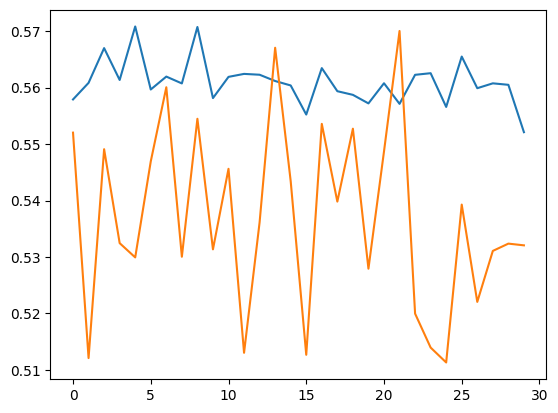

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

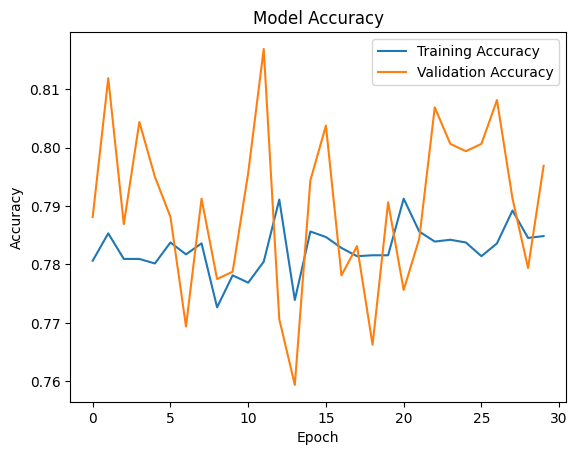

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()